In [30]:
#%%
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime
from datetime import timedelta
import pickle   
import numpy as np
from numba import jit

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.collections as mcoll
import seaborn as sns
import tcmarkers

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import netCDF4 as nc

from ty_pkg_copy import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg_copy import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups

import time

with open(r'/home1/jek/Pangu-Weather/code/s2s/data/wmo_data.pkl', 'rb') as file:
    wmo_data = pickle.load(file)
    
with open(r'/home1/jek/Pangu-Weather/code/s2s/data/jtwc_data.pkl', 'rb') as file:
    jtwc_data = pickle.load(file)
    
    
@jit(nopython=True)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def ensemble_data_maker(file_name):
    # XML 파일 파싱
    tree = ET.parse(f'{file_name}.xml')
    root = tree.getroot()

    # 모든 'data' 요소에 대하여 처리
    ensemble_data = {}
    for data in root.findall('.//data'):
        if data.get('member') == None:
            continue
        member = int(data.get('member'))
        # print(member)
        perturb = data.get('perturb')

        # 멤버 별로 데이터 구성
        if member not in ensemble_data:
            ensemble_data[member] = {}

        # 각 'disturbance' 요소 처리
        for disturbance in data.findall('.//disturbance'):
            disturbance_id = disturbance.get('ID')
            basin = disturbance.find('basin').text
            
            if disturbance_id.endswith('00E'):
                continue
            
            # Basin이 Northwest Pacific인 경우만 데이터 저장
            if basin == "Northwest Pacific":
                
                # disturbance ID 별로 데이터 구성
                if disturbance_id not in ensemble_data[member]:
                    ensemble_data[member][disturbance_id] = {}

                # 각 'fix' 요소에서 위치와 기압 데이터 추출
                for fix in disturbance.findall('fix'):
                    valid_time = fix.find('validTime').text
                    valid_time = datetime.strptime(valid_time,"%Y-%m-%dT%H:%M:%SZ")
                    latitude = float(fix.find('latitude').text)
                    longitude = float(fix.find('longitude').text)
                    pressure = float(fix.find('.//pressure').text)
                    
                    ensemble_data[member][disturbance_id][valid_time] = {
                        'lon': longitude, 'lat': latitude, 'pres': pressure
                    }


    return ensemble_data

def nc_dict(file_name):
    with nc.Dataset(f'{file_name}.nc', 'r') as dataset:
        ensemble_data = {}
        for member_name in dataset.groups:
            member = int(member_name.split('_')[1])  # Extract member number
            ensemble_data[member] = {}
            member_group = dataset.groups[member_name]
            
            for disturbance_id in member_group.groups:
                disturbance_group = member_group.groups[disturbance_id]
                ensemble_data[member][disturbance_id] = {}
                
                times_var = disturbance_group.variables['time']
                if hasattr(times_var, 'units') and hasattr(times_var, 'calendar'):
                    # Converting time data
                    times = nc.num2date(times_var[:], units=times_var.units, calendar=times_var.calendar)
                    # Ensure all times are standard datetime objects
                    times = [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in times]
                else:
                    raise ValueError("print out Time variable is missing 'units' or 'calendar' attributes")

                latitudes = disturbance_group.variables['lat'][:]
                longitudes = disturbance_group.variables['lon'][:]
                pressures = disturbance_group.variables['pres'][:]
                
                for i, t in enumerate(times):
                    ensemble_data[member][disturbance_id][t] = {
                        'lat': latitudes[i], 'lon': longitudes[i], 'pres': pressures[i]
                    }
    return ensemble_data

def colorline(ax, x, y, z=None, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1.0, zorder=5):
    # x, y는 선의 좌표, z는 색상에 사용될 값
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    
    # z 값을 정규화
    z = np.asarray(z)

    # 선분을 색상으로 구분하여 그리기
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, zorder=zorder)
    
    ax.add_collection(lc)
    
    return lc

def set_map(row = 1, col = 1, size = (10,8) ,back_color = 'n', proj  = ccrs.PlateCarree(0), extent = None):
    fig, ax = plt.subplots(row, col, figsize = size, subplot_kw={'projection': proj})
    gl = ax.gridlines(crs=ccrs.PlateCarree(0), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10)) 
    
    if extent != None:
        ax.set_extent(extent)
        
    ax.coastlines('10m')
    if back_color == 'y':
        ocean_color = mcolors.to_rgba((147/255, 206/255, 229/255))
        land_color = mcolors.to_rgba((191/255, 153/255, 107/255))
        ax.add_feature(cfeature.OCEAN, color=ocean_color)
        ax.add_feature(cfeature.LAND, color=land_color, edgecolor='none')
    
    return fig, ax


In [ ]:
#%%
target_date = '2022082800'
# file_name = f"/home1/jek/Pangu-Weather/input_data/TIGGE/ecmf/{target_date[:4]}/{target_date[:8]}/z_tigge_c_ecmf_{target_date}0000_ifs_glob_test_all_glo"
file_name = f"/home1/jek/Pangu-Weather/input_data/TIGGE/ecmf/{target_date[:4]}/{target_date[:8]}/z_tigge_c_ecmf_{target_date}0000_ifs_glob_prod_all_glo"
file_name = f"/home1/jek/Pangu-Weather/input_data/TIGGE/ecmf/{target_date[:4]}/{target_date[:8]}/z_tigge_c_ecmf_{target_date}0000_ifs_glob_prod_all_glo"
# file_name = f"/home1/jek/Pangu-Weather/input_data/TIGGE/rksl/2022/20220828/z_tigge_c_rksl_20220828120000_GEPS_glob_prod_etctr_nwp.xml"
ensemble_data = nc_dict(file_name)

fig, ax = set_map(proj = ccrs.PlateCarree(0), extent = [110,160,10,45], size = (10,7), back_color='y')
ax.set_title(f'{target_date}')

for mem, mem_data in ensemble_data.items():
    if mem == 0:
        for tc, tc_data in mem_data.items():
            lon = [v['lon'] for i,v in tc_data.items()]
            lat = [v['lat'] for i,v in tc_data.items()]
            pres = [v['pres'] for i,v in tc_data.items()]
            # lc = colorline(ax, lon, lat, z=pres, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=950, vmax=1020), linewidth=2, alpha=1)
            # ax.scatter(lon, lat, c = pres)
            lc = colorline(ax, lon, lat, z=pres, linewidth=1.5)
        break
cb = plt.colorbar(lc, shrink = 0.7)
cb.set_label('$hPa$')

FileNotFoundError: [Errno 2] No such file or directory: '/home1/jek/Pangu-Weather/input_data/TIGGE/ecmf/2022/20220828/z_tigge_c_ecmf_20220828000000_ifs_glob_prod_all_glo.nc'

In [47]:
import sys, os
from urllib.request import build_opener

opener = build_opener()

filelist = [
  'https://data.rda.ucar.edu/d330003/ecmf/2022/20220828/z_tigge_c_ecmf_20220821200000_ifs_glob_prod_all_glo.xml'
]

destination_dir = "/home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor"  # 원하는 저장 폴더 경로


for file in filelist:
    ofile = os.path.join(destination_dir, os.path.basename(file))  # 저장 위치 수정
    sys.stdout.write("downloading " + ofile + " ... ")
    sys.stdout.flush()
    infile = opener.open(file)
    with open(ofile, "wb") as outfile:
        outfile.write(infile.read())
    sys.stdout.write("done\n")

downloading /home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor/z_tigge_c_ecmf_20220821200000_ifs_glob_prod_all_glo.xml ... 

HTTPError: HTTP Error 404: Not Found

In [21]:
import xml.etree.ElementTree as ET

# Path to your XML file
xml_file = "/home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor/ammc_2812.xml"


# Parse the XML file
tree = ET.parse(xml_file)
root = tree.getroot()

# Set the target validTime to filter disturbances
target_valid_time = "2022-08-28T12:00:00Z"

# Initialize a list to store latitude and longitude data
lat_lon_data = []

# Extract the specific disturbance with the matching validTime
for data in root.findall(".//data[@type='ensembleForecast']"):
    member = data.get('member')
    perturb = data.get('perturb')

    # Loop through all disturbances
    for disturbance in data.findall(".//disturbance"):
        
        # Find the fix with the matching validTime
        for fix in disturbance.findall(".//fix"):
            valid_time = fix.find("validTime").text if fix.find("validTime") is not None else None
            
            if valid_time == target_valid_time:
                # If validTime matches, extract latitude and longitude for all times in this disturbance
                for all_fix in disturbance.findall(".//fix"):
                    latitude = float(all_fix.find("latitude").text) if all_fix.find("latitude") is not None else None
                    longitude = float(all_fix.find("longitude").text) if all_fix.find("longitude") is not None else None
                    time = all_fix.find("validTime").text if all_fix.find("validTime") is not None else None
                    
                    # Store the lat, lon, and validTime
                    lat_lon_data.append({
                        'validTime': time,
                        'latitude': latitude,
                        'longitude': longitude
                    })

# Output the latitude and longitude data for the disturbance across all time steps
for entry in lat_lon_data:
    print(f"Time: {entry['validTime']}, Latitude: {entry['latitude']}, Longitude: {entry['longitude']}")

In [ ]:
import os
import re

folder_path = '/home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor_ens'

# 파일명에서 모델 키와 start_time 추출을 위한 정규식 패턴 (예제에 맞게 수정 가능)
pattern = re.compile(r"z_tigge_c_(\w+)_([\d]{10,})_ifs_glob_prod_all_glo\.xml")

# 폴더 내 파일 리스트 확인
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # 파일명이 정규식 패턴과 일치하는 경우만 처리
    match = pattern.match(filename)
    if match:
        model_key = match.group(1)  # 모델 키 (예: 'ecmf')
        start_time = match.group(2)  # 시작 시간 (예: '20220801000000')

        # 새로운 파일명 생성
        new_filename = f"{model_key}_{start_time}.xml"
        new_file_path = os.path.join(folder_path, new_filename)

        # 파일 이름 변경
        os.rename(file_path, new_file_path)
        print(f"Renamed: {filename} → {new_filename}")

In [31]:
#Drawing only hinnamnor control ENS
# from ty_pkg import latlon
import xml.etree.ElementTree as ET
import os
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import xarray as xr


pangu_dir = r'/home1/jek/Pangu-Weather'

input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/29/12UTC'
pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
steer_pres = [850,700,600,500,400,300,250]
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)



#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(0,359.9,-90,90)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ds = xr.open_dataset(rf'/home1/jek/Pangu-Weather/input_data/IBTrACS.WP.v04r01.nc')
hin_ds = ds.where((ds['season'] == 2022) & (ds['name'] == b'HINNAMNOR'), drop=True)
storm_lat, storm_lon, storm_time, storm_speed, storm_type = hin_ds['usa_lat'][0].values.astype(np.float32), hin_ds['usa_lon'][0].values.astype(np.float32), hin_ds['iso_time'][0].values.astype('datetime64').astype(datetime), hin_ds['usa_wind'][0].values.astype(np.float32), hin_ds['nature'][0].values.astype('str')
storm_usa_type = hin_ds['usa_status'][0].values.astype('str')

storm_lat = storm_lat[(storm_lat != '') & (storm_lat != None)]
storm_lon = storm_lon[(storm_lon != '') & (storm_lon != None)]
storm_time = storm_time[(storm_time != '') & (storm_time != None)]
storm_speed = storm_speed[(storm_speed != '') & (storm_speed != None)]
storm_type = storm_type[(storm_type != '') & (storm_type != None)]
storm_usa_type = storm_usa_type[(storm_usa_type != '') & (storm_usa_type != None)]

def map_gridlines(ax, proj = ccrs.PlateCarree(), font_size = 15, gridline_spaces = 10):
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder= 0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': font_size}
    gl.ylabel_style = {'size': font_size}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, gridline_spaces))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, gridline_spaces))

model name: ECMWF, len: 98
model name: ECMWF, len: 102
model name: ECMWF, len: 102
model name: ECMWF, len: 100
model name: ECMWF, len: 102
model name: ECMWF, len: 100
model name: ECMWF, len: 102
model name: ECMWF, len: 98
model name: ECMWF, len: 96
model name: ECMWF, len: 88
model name: ECMWF, len: 86
model name: ECMWF, len: 72
model name: ECMWF, len: 70
model name: ECMWF, len: 66
model name: ECMWF, len: 68
model name: ECMWF, len: 70
model name: ECMWF, len: 68
model name: ECMWF, len: 68
model name: ECMWF, len: 64
model name: ECMWF, len: 60
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 60
model name: ECMWF, len: 54
model name: ECMWF, len: 56
model name: ECMWF, len: 54
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 56
model name: ECMWF, len: 54
model name: ECMWF, lon: [149.28979591836733, 148.66470588235296, 147.8392156

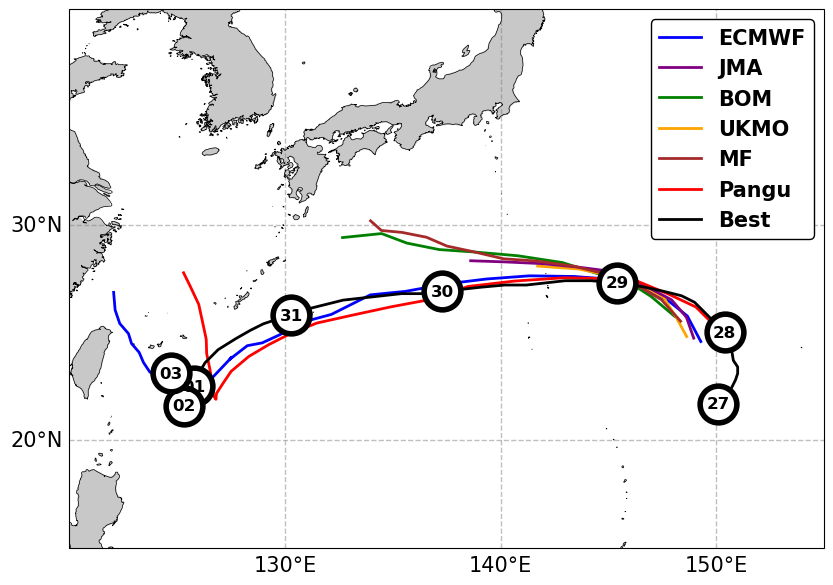

In [32]:


fig, ax = plt.subplots(1,1, figsize = (10,7), subplot_kw={'projection': ccrs.PlateCarree(0)})
map_gridlines(ax)
ax.add_feature(cfeature.LAND, color=mcolors.to_rgba((200/255, 200/255, 200/255)), edgecolor='none')
ax.set_extent([120,155,15,40], crs=proj)
ax.coastlines('10m', linewidth=0.5)

start_time = ['2800']
operation = 'ecmf'
    
# xml_file = "/home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor/ammc_2800.xml"
model_dict = {
    'ecmf': 'ECMWF',
    'ammc': 'BOM',
    'eggr': 'UKMO',
    'rjtd': 'JMA',
    'ifpw': 'MF',
    # 'GEFS': 'NCEP',
    # 'CENS': 'CA',
}
# model_dict = {
#     # 'ecmf': 'ECMWF',
#     # 'ammc': 'BOM',
#     # 'eggr': 'MET',
#     'RJTD': 'JMA',
#     # 'ifpw': 'FR',
#     # 'GEFS': 'NCEP',
#     # 'CENS': 'CA',
# }
# model_keys = ['ecmf', 'rjtd','ammc', 'eggr', 'ifpw']
# model_keys = ['rjtd']
color_list = ['blue', 'green', 'orange', 'purple', 'brown']
# color_list = ['blue']
model_colors = dict(zip(model_dict.keys(), color_list))
# colors = mcolors.TABLEAU_COLORS  # Using tableau colors for distinctiveness
# color_list = list(colors.values())[:len(model_keys)]  # Assigning distinct colors to the model keys

# # Creating a dictionary with model keys and their corresponding colors

# Path to the Hinnamnor folder
folder_path = '/home1/jek/Pangu-Weather/input_data/TIGGE/Hinnamnor_non_ens'

# Initialize a list to store files with '_2800'
file_list = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file contains '_2800'
    if f'_{start_time}' in file_name:
        # Extract the part of the filename that comes before '_2800'
        prefix = file_name.split(f'_{start_time}')[0]
        
        # Add the file name and prefix to the list
        file_list.append((file_name, prefix))

if operation in model_dict:
    file_list = [(f'{operation}_{start_time}.xml',operation)]
# file_list = [('GEFS_2806.xml','GEFS')]

for model_name in model_dict:
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # if not isinstance(file_path, str):  # filename이 튜플이 아닐 때만 처리
        #     file_path = str(file_path)

        
        # 파일인지 확인하고, 파일명에 model_name과 start_time이 포함되는지 체크
        if model_name in file_name and start_time[0] in file_name:
            tree = ET.parse(file_path)
            root = tree.getroot()



            # Set the target validTime to filter disturbances
            target_valid_time = "2022-08-28T12:00:00Z"


            # Latitude and longitude condition ranges
            lat_min, lat_max = 25, 30
            lon_min, lon_max = 145, 150

            # Initialize a list to store latitude and longitude data

            lons = {}
            lats = {}

            ens_lons = {}
            ens_lats = {}
            # draw ENS_model
            # Extract the specific disturbance with the matching validTime
            for data in root.findall(".//data[@type='ensembleForecast']"):
                member = data.get('member')
                perturb = data.get('perturb')
                mem = member
                # print(member)
                ens_lons[mem] = []
                ens_lats[mem] = []
                
                # if perturb == 'control':
                    # Loop through all disturbances
                for disturbance in data.findall(".//disturbance"):
                    
                    # Loop through all fixes to find the specific validTime
                    for fix in disturbance.findall(".//fix"):
                        valid_time = fix.find("validTime").text if fix.find("validTime") is not None else None
                        
                        if valid_time == target_valid_time:
                            # Get the latitude and longitude at this time
                            latitude = float(fix.find("latitude").text) if fix.find("latitude") is not None else None
                            longitude = float(fix.find("longitude").text) if fix.find("longitude") is not None else None
                            # print(latitude)
                            # Apply the conditions for latitude and longitude range
                            if lat_min <= latitude <= lat_max and lon_min <= longitude <= lon_max:
                                
                                
                                # If the conditions are met, extract all lat, lon for this disturbance at all times
                                for all_fix in disturbance.findall(".//fix"):
                                    lat = float(all_fix.find("latitude").text) if all_fix.find("latitude") is not None else None
                                    lon = float(all_fix.find("longitude").text) if all_fix.find("longitude") is not None else None
                                    time = all_fix.find("validTime").text if all_fix.find("validTime") is not None else None
                                    
                                    # Store the lat, lon, and validTime for this disturbance
                                    # lat_lon_data.append({
                                    #     'validTime': time,
                                    #     'latitude': lat,
                                    #     'longitude': lon
                                    # })

                                    if time not in lons:
                                        lons[time] = []
                                        lats[time] = []

                                    lons[time].append(lon)
                                    lats[time].append(lat)
                                    ens_lons[mem].append(lon)
                                    ens_lats[mem].append(lat)
                # if lons[:int(len(lons)/2)] == lons[int(len(lons)/2):]:
                #     lons = lons[:int(len(lons)/2)]
                #     lats = lats[:int(len(lats)/2)]
            tc_lons, tc_lats = [], []
            max_len = 0
            

            for t in lons:
                if max_len < len(lons[t]):
                    max_len = len(lons[t])
            
            for t in lons:
                if len(lons[t]) < max_len/2:
                    break
                tc_lons.append(np.mean(lons[t]))
                tc_lats.append(np.mean(lats[t]))
                print(f"model name: {model_dict[model_name]}, len: {len(lons[t])}")

                # print(model_name)
                # print(lons)
            
            print(f"model name: {model_dict[model_name]}, lon: {tc_lons}, lat: {tc_lats}")
            ax.plot(tc_lons, tc_lats, label = f'{model_dict[model_name]}', color = model_colors[model_name], linewidth = 2, zorder = 10)

    # Draw all ENS in the model
    # for mem in ens_lons:
    #     if ens_lons[mem][:int(len(ens_lons[mem])/2)] == ens_lons[mem][int(len(ens_lons[mem])/2):]:
    #         ens_lons[mem] = ens_lons[mem][:int(len(ens_lons[mem])/2)]
    #         ens_lats[mem] = ens_lats[mem][:int(len(ens_lats[mem])/2)]
    #     ax.plot(ens_lons[mem], ens_lats[mem], alpha = 0.2, color = model_colors[model_name], linewidth = 1)
        



    
color_dict = {'DB': 'cyan', 'TD': 'cyan', 'TS': 'green', 'TY': 'orange', 'ST': 'red', 'SSW': 'purple', 'EX': 'gray'}
type_colors = [color_dict[t] for t in storm_usa_type if t in color_dict]

legend_handles = []
# Keep track of which labels have already been added to avoid duplicates
added_labels = set()

# Define the order and mapping for your legend labels
legend_labels_order = {'TD': 'TD', 'TS': 'TS', 'TY': 'TY', 'ST': 'ST'}



ax.plot(storm_lon[:57], storm_lat[:57], color='black', linestyle='-', marker='', transform=ax.projection, zorder=16, linewidth=2, label = 'Best')
for i in range(len(storm_usa_type))[:57:2]:
    new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
    if new_time.endswith('00UTC'):
        ax.scatter(storm_lon[i], storm_lat[i], color='w', transform=ax.projection, zorder=16, s=700, edgecolors='black', linewidth=4)
        ax.text(storm_lon[i], storm_lat[i], new_time[8:-6]
                , horizontalalignment='center', verticalalignment='center', fontsize=12, zorder = 20, fontweight = 'bold')





# met = Met(input_data_dir, '', surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'y')

# u = met.met_data('u', level = 'all')
# v = met.met_data('v', level = 'all')
# # steer_pres를 문자열 리스트로 변환
# steer_pres_str = list(map(str, steer_pres))
# # 인덱스 찾기
# indices = np.array([pres_list.index(p) for p in steer_pres_str if p in pres_list])
# u = u[indices,:,:] 
# v = v[indices,:,:]

# # steer_pres 간격 계산 (앞뒤 간격 평균)
# diffs = np.diff(steer_pres)  # 각 간격 계산
# weights = np.zeros_like(steer_pres, dtype=np.float64)  # 가중치 배열 생성

# # 앞뒤 간격 평균 계산
# weights[1:-1] = (diffs[:-1] + diffs[1:]) / 2  # 중간 값은 앞뒤 간격 평균
# weights[0] = diffs[0]  # 첫 번째 값은 첫 간격 그대로
# weights[-1] = diffs[-1]  # 마지막 값은 마지막 간격 그대로

# # u, v를 steer_pres의 간격에 따라 가중 평균 (axis=1, pressure level 축)
# u_steer = np.average(u, axis=0, weights=weights)
# v_steer = np.average(v, axis=0, weights=weights)



# lat_rad = np.radians(lat_grid)
# lon_rad = np.radians(lon_grid)

# # 위도/경도 간격 (라디안 기준)
# dlat = np.gradient(lat_rad, axis=0)
# dlon = np.gradient(lon_rad, axis=1)

# # 거리 기준 간격
# R = 6.371e6  # meters
# dx = R * np.cos(lat_rad) * dlon  # (남북 간격마다 다름)
# dy = R * dlat                    # (동서 간격마다 다름)

# # 각도 → 거리로 환산하여 gradient 계산
# du_dy = np.gradient(u_steer, axis=0) / dy
# dv_dx = np.gradient(v_steer, axis=1) / dx
# vort = dv_dx - du_dy

# du_dx = np.gradient(u_steer, axis=1) / dx
# dv_dy = np.gradient(v_steer, axis=0) / dy
# div = du_dx + dv_dy
# # ty_wind = WindFieldSolver(lats, lons, TC_lat, TC_lon, vort, div)
# # ty_wind = WindFieldSolver(lat_grid, lon_grid, 25.90, 130.30, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
# ty_wind = WindFieldSolver(lat_grid, lon_grid, 22.50, 125.70, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
# u_ty, v_ty = ty_wind.solve()

#%%
#! 태풍 경로 정보 기존 정보 불러오기

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
perturation_scale = 0.05

key_time_list = ['2022/08/28/00UTC']
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,100)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''

for first_str in key_time_list:
    first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
    key_str = first_time.strftime("%m.%d.%HUTC")
    ssv_key = first_time
    surface_factors.sort()
    upper_factors.sort()
    surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
    upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
    
    datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
    # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])

    
    with open(rf'/home1/jek/Pangu-Weather/output_data/2022/08/28/00UTC/0.05ENS_z/ssv_dict_td_0_99.pkl', 'rb') as f:
        ssv_dict = pickle.load(f)

for key_time ,min_position in ssv_dict.items():
    tc_lons = {}
    tc_lats = {}
    for ens in ens_list:  
        lons = [pos['lon'] for _,pos in min_position[ens].items()]
        lats = [pos['lat'] for _,pos in min_position[ens].items()]
        min_values = [pos['mslp'] for _,pos in min_position[ens].items()]
        pred_times = [pos for pos,_ in min_position[ens].items()]

        for i, t in enumerate(pred_times):
            if t not in tc_lons:
                tc_lons[t] = []
                tc_lats[t] = []

            tc_lons[t].append(lons[i])
            tc_lats[t].append(lats[i])

    mean_lons = []
    mean_lats = []
    for t in tc_lons:
        print(f'time: {t}, len: {len(tc_lons[t])}')
        if len(tc_lons[t]) >= 50 :
            mean_lons.append(np.mean(tc_lons[t]))
            mean_lats.append(np.mean(tc_lats[t]))
    
ax.plot(mean_lons, mean_lats, linewidth = 2, color = 'red', label = 'Pangu', zorder = 10)
# ax.plot(storm_lon, storm_lat, color = 'red', linewidth = 2, label = 'Best')
# ax.streamplot(lon_grid, lat_grid, u_steer-u_ty, v_steer-v_ty, transform=proj, color='black', linewidth=1, density=1, zorder = 0)
# --- 범례 순서 재정렬 ---
# 1. 현재 axes에서 모든 핸들(선/마커)과 레이블을 가져옵니다.
handles, labels = ax.get_legend_handles_labels()

# 2. 원하는 순서를 정의합니다.
# 'Best'를 가장 아래에 두고 싶으므로, 나머지 레이블들을 먼저 정의하고 'Best'를 맨 뒤에 추가합니다.
# 이 리스트는 범례에 표시될 모든 레이블을 포함해야 합니다.
# 실제 레이블 이름과 정확히 일치해야 합니다.
desired_order = [
    'ECMWF',   # (예시) 실제 사용된 모델이 여러 개라면 여기에 추가하세요
    'JMA',     # (예시)
    'BOM',     # (예시)
    'UKMO',    # (예시)
    'MF',      # (예시)
    'Pangu',
    'Best'
]

# 3. desired_order에 따라 핸들 및 레이블을 재정렬합니다.
# 이 과정은 효율성을 위해 딕셔너리를 사용하는 것이 좋습니다.
# 먼저 label: handle 매핑을 만듭니다.
label_to_handle = dict(zip(labels, handles))

# 원하는 순서대로 handles와 labels 리스트를 새로 만듭니다.
ordered_handles = [label_to_handle[label] for label in desired_order if label in label_to_handle]
ordered_labels = [label for label in desired_order if label in label_to_handle]

# 4. 재정렬된 핸들 및 레이블로 범례를 다시 그립니다.
ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    loc='upper right',
    framealpha=1,
    facecolor='white',
    edgecolor='black',
    prop={'weight': 'bold', 'size': 15}
)
plt.show()


#! 당시 태풍 위치 넣기기

In [45]:
storm_lon, storm_lat, storm_mslp, storm_time

(array([149.3, 148.3, 146.9, 145.3, 143.2, 141.3, 139.3, 137.4, 135.4,
        133.6, 131.9, 130.3, 129. , 127.7, 126.5, 125.8, 125.5, 125.6,
        125.5, 125.4, 125.1, 124.7, 124.7, 124.7, 124.7, 124.7, 124.6,
        124.5]),
 array([25.8, 26.7, 27.2, 27.3, 27.4, 27.3, 27.1, 26.8, 26.7, 26.5, 26.3,
        25.9, 25.4, 24.8, 24. , 22.6, 21.8, 21.3, 21.4, 21.5, 22. , 22.2,
        22.4, 23.1, 23.7, 24.5, 25.1, 26.1]),
 array([1002,  999,  996,  990,  978,  959,  936,  944,  932,  926,  920,
         924,  926,  930,  931,  915,  921,  935,  936,  952,  964,  962,
         967,  963,  959,  956,  952,  941]),
 array([datetime.datetime(2022, 8, 28, 6, 0),
        datetime.datetime(2022, 8, 28, 12, 0),
        datetime.datetime(2022, 8, 28, 18, 0),
        datetime.datetime(2022, 8, 29, 0, 0),
        datetime.datetime(2022, 8, 29, 6, 0),
        datetime.datetime(2022, 8, 29, 12, 0),
        datetime.datetime(2022, 8, 29, 18, 0),
        datetime.datetime(2022, 8, 30, 0, 0),
        da

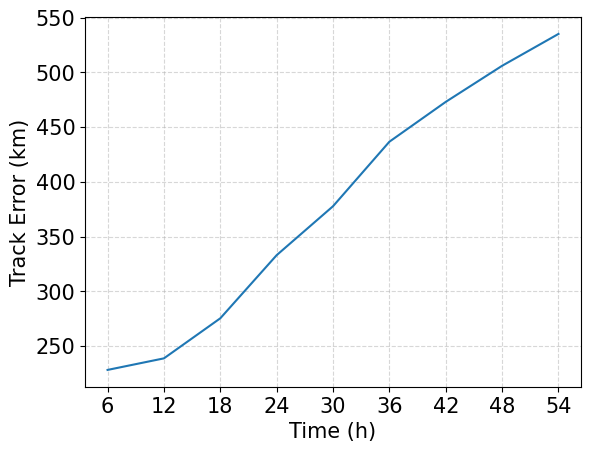

In [55]:

track_error_list = []
for i, (jma_lon, jma_lat, mean_lon, mean_lat) in enumerate(zip(jma_lons, jma_lats, storm_lon[1:10], storm_lat[1:10])):
    # print(jma_lon, jma_lat, mean_lon, mean_lat)
    track_error = haversine_distance(jma_lat, jma_lon, mean_lat, mean_lon)
    # print(f"Distance between JMA and Pangu at time {i}: {track_error:.2f} km")

    track_error_list.append(track_error)
plt.plot(range(6, (len(jma_lons) + 1) * 6, 6), track_error_list)

# axis labels
plt.xlabel('Time (h)', fontsize=15)
plt.ylabel('Track Error (km)', fontsize=15)

# tick locations + font size
plt.xticks(range(6, (len(jma_lons) + 1) * 6, 6), fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

ammc	Autralia Bureau of Meteorology	4761

babj	China Meteorological Administration	1170

ecmf	European Center for Medium-Range Weather Forecasts	9535

egrr	United Kingdom Met Office	20136

kwbc	National Centers for Environmental Prediction (USA) and Meteorological Service of Canada	73310

lfpw	MeteoFrance	5997

rjtd	Japan Meteorological Agency	28059

rksl	Korea Meteorological Administration	2622

In [83]:
#%%
import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import plotly.figure_factory as ff
import matplotlib.collections as mcoll
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from geopy.distance import geodesic
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.ticker as ticker
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from skimage.measure import regionprops
from sklearn.decomposition import PCA

import scipy.ndimage as ndimage
from scipy.stats import gaussian_kde
from scipy.interpolate import interpn
from scipy.ndimage import binary_dilation, minimum_filter, maximum_filter, label
from scipy import integrate
from scipy.sparse import diags, kron
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups


input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/31/00UTC'
pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
steer_pres = [850,700,600,500,400,300,250]
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)




In [7]:
#best track 그리기
storm_name = 'hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022
storm_lon, storm_lat, storm_mslp, storm_time = storm_info('/home1/jek/Pangu-Weather', storm_name, storm_year, wind_thres=0)



pangu_dir = r'/home1/jek/Pangu-Weather'

input_data_dir = '/home1/jek/Pangu-Weather/input_data/2022/08/31/00UTC'
pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
steer_pres = [850,700,600,500,400,300,250]
pres=500                                                #살펴볼 기압면 결정
p=pres_list.index(str(pres))
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)



#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(0,359.9,-90,90)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])

met = Met(input_data_dir, '', surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'y')

u = met.met_data('u', level = 'all')
v = met.met_data('v', level = 'all')
# steer_pres를 문자열 리스트로 변환
steer_pres_str = list(map(str, steer_pres))
# 인덱스 찾기
indices = np.array([pres_list.index(p) for p in steer_pres_str if p in pres_list])
u = u[indices,:,:] 
v = v[indices,:,:]

# steer_pres 간격 계산 (앞뒤 간격 평균)
diffs = np.diff(steer_pres)  # 각 간격 계산
weights = np.zeros_like(steer_pres, dtype=np.float64)  # 가중치 배열 생성

# 앞뒤 간격 평균 계산
weights[1:-1] = (diffs[:-1] + diffs[1:]) / 2  # 중간 값은 앞뒤 간격 평균
weights[0] = diffs[0]  # 첫 번째 값은 첫 간격 그대로
weights[-1] = diffs[-1]  # 마지막 값은 마지막 간격 그대로

# u, v를 steer_pres의 간격에 따라 가중 평균 (axis=1, pressure level 축)
u_steer = np.average(u, axis=0, weights=weights)
v_steer = np.average(v, axis=0, weights=weights)



lat_rad = np.radians(lat_grid)
lon_rad = np.radians(lon_grid)

# 위도/경도 간격 (라디안 기준)
dlat = np.gradient(lat_rad, axis=0)
dlon = np.gradient(lon_rad, axis=1)

# 거리 기준 간격
R = 6.371e6  # meters
dx = R * np.cos(lat_rad) * dlon  # (남북 간격마다 다름)
dy = R * dlat                    # (동서 간격마다 다름)

# 각도 → 거리로 환산하여 gradient 계산
du_dy = np.gradient(u_steer, axis=0) / dy
dv_dx = np.gradient(v_steer, axis=1) / dx
vort = dv_dx - du_dy

du_dx = np.gradient(u_steer, axis=1) / dx
dv_dy = np.gradient(v_steer, axis=0) / dy
div = du_dx + dv_dy
# ty_wind = WindFieldSolver(lats, lons, TC_lat, TC_lon, vort, div)
ty_wind = WindFieldSolver(lat_grid, lon_grid, 25.90, 130.30, div, vort, radius=333, dx=111e3/4, dy=111e3/4)
u_ty, v_ty = ty_wind.solve()

plt.quiver(lon_grid, lat_grid, u_steer, v_steer, transform=proj)

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._subplots.AxesSubplot'>

<Figure size 640x480 with 1 Axes>

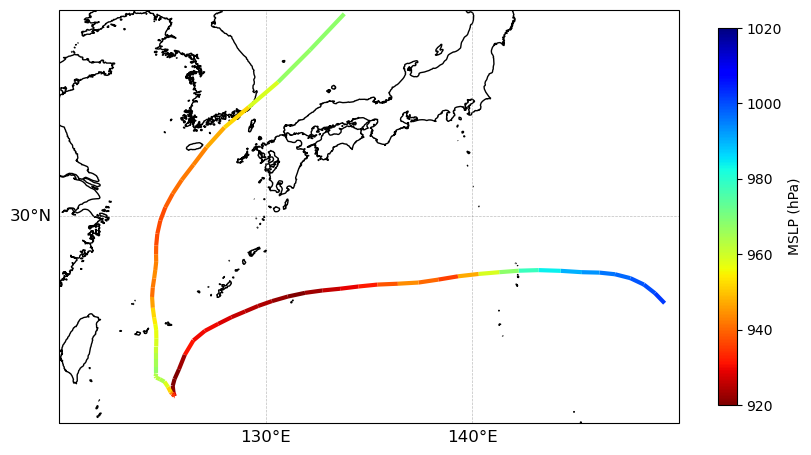

In [34]:
storm_name = 'hinnamnor'                                                                               
storm_name = storm_name.upper()
storm_year = 2022
storm_lon, storm_lat, storm_mslp, storm_time = storm_info('/home1/jek/Pangu-Weather', storm_name, storm_year, wind_thres=0)



fig, ax = plt.subplots(1, 1, figsize=(10, 7), subplot_kw={'projection': proj})

ax.set_extent([120, 150, 20, 40], crs=proj)
ax.coastlines('10m')
# ax.plot(storm_lon, storm_lat, color='black', linewidth=2, label='Best Track')
ac = colorline(ax, storm_lon, storm_lat, z=storm_mslp, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=920, vmax=1020), linewidth=3, alpha=1)
plt.colorbar(ac, label='MSLP (hPa)', shrink=0.7, pad = 0.05)

gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl.xlocator = mticker.FixedLocator(np.arange(120, 151, 10))
gl.ylocator = mticker.FixedLocator(np.arange(20, 41, 10))

# ocean_color = mcolors.to_rgba((147/255, 206/255, 229/255))
# land_color = mcolors.to_rgba((191/255, 153/255, 107/255))
# ax.add_feature(cfeature.OCEAN, color=ocean_color)
# ax.add_feature(cfeature.LAND, color=land_color, edgecolor='none')



In [ ]:
#%%


    #결정 모델 그리기
    # for data in root.findall(".//data[@type='forecast']"):
    #     print(model_name)
    #     lons = []
    #     lats = []
    #     vts = []
        
    #     # if perturb == 'control':
    #         # Loop through all disturbances
    #     for disturbance in data.findall(".//disturbance"):
            
    #         # Loop through all fixes to find the specific validTime
    #         for fix in disturbance.findall(".//fix"):
    #             valid_time = fix.find("validTime").text if fix.find("validTime") is not None else None
                
    #             if valid_time == target_valid_time:
    #                 # Get the latitude and longitude at this time
    #                 latitude = float(fix.find("latitude").text) if fix.find("latitude") is not None else None
    #                 longitude = float(fix.find("longitude").text) if fix.find("longitude") is not None else None
    #                 # print(latitude)
    #                 # Apply the conditions for latitude and longitude range
    #                 if lat_min <= latitude <= lat_max and lon_min <= longitude <= lon_max:
                        
    #                     # If the conditions are met, extract all lat, lon for this disturbance at all times
    #                     for all_fix in disturbance.findall(".//fix"):
    #                         lat = float(all_fix.find("latitude").text) if all_fix.find("latitude") is not None else None
    #                         lon = float(all_fix.find("longitude").text) if all_fix.find("longitude") is not None else None
    #                         time = all_fix.find("validTime").text if all_fix.find("validTime") is not None else None
                            
    #                         # Store the lat, lon, and validTime for this disturbance
    #                         # lat_lon_data.append({
    #                         #     'validTime': time,
    #                         #     'latitude': lat,
    #                         #     'longitude': lon
    #                         # })
    #                         vts.append(time)
    #                         lons.append(lon)
    #                         lats.append(lat)

        
    #     if lons[:int(len(lons)/2)] == lons[int(len(lons)/2):]:
    #         lons = lons[:int(len(lons)/2)]
    #         lats = lats[:int(len(lats)/2)]
        


    #     ax.plot(lons, lats, label = f'{model_dict[model_name]}')
    #     break